# Changes:

1. Use 1st ver UNET
2. Use the Augmentor Package to augment data
3. BCE loss + lovasz loss
4. Bilinear Upsampling
Best Val IOU: 0.8142 at epoch 176

Fine Tuning

1. Fined tuned for another 40 epochs and Best Val IOU: 0.8193
Use BCE + 0.1*lovasz loss. Leaderboard IOU: 0.797

2. Fine tuned for 80 epochs with more data aug and focal loss and best IOU is 0.8059

3. Fine tuned for 100 epochs with less data aug(only hflip), bce loss and lovasz loss. best IOU is 0.8154 at epoch 15, training not done yet.




## Install required packages if running on google colab

In [0]:
try:
    import torch
except:
    !pip install torch torchvision
    !pip install imageio
    !pip install Augmentor
    !git clone https://github.com/allen-q/salt_oil.git
    !git clone https://github.com/allen-q/salt_net.git

In [2]:
cd salt_oil/

/content/salt_oil


## Import required libs

In [0]:
import zipfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import os
import imageio
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time
import math
import datetime as dt
import pytz
import pickle
from salt_func_lib import *
from torchvision import transforms, utils
from skimage import io, transform
import datetime as dt
import sys
from optparse import OptionParser
import torch.backends.cudnn as cudnn
from torch import optim
from torch.optim import lr_scheduler
import copy
from io import BytesIO
import Augmentor
import random
import PIL
% matplotlib inline
% load_ext autoreload
% autoreload 2

## Load Unet Modules

In [0]:
from pytorch_unet.eval import eval_net
from pytorch_unet.unet import UNet
from pytorch_unet.unet.unet_parts import *
from pytorch_unet.utils import get_ids, split_ids, split_train_val, get_imgs_and_masks, batch

In [0]:
## Setup data type based on whether GPU is enabled

In [0]:
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!
else:    
    dtype = torch.FloatTensor

In [7]:
print(f'Data Type set to: {dtype}')

Data Type set to: <class 'torch.cuda.FloatTensor'>


## Create Global Variables

In [0]:
def init_global_variables():
    """initialize global variables such as db connection, logger etc."""
    global log
    log = get_logger('SaltNet')

In [0]:
init_global_variables()

In [0]:
class SaltDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, np_img, np_mask, df_depth, mean_img, out_size=101, out_ch=1, transform=None):
        """
        Args:
            data_dir (string): Path to the image files.
            train (bool): Load train or test data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.np_img = np_img
        self.np_mask = np_mask.clip(0,1)
        self.df_depth = df_depth
        self.mean_img = mean_img
        self.out_size = out_size
        self.out_ch = out_ch
        self.transform = transform

    def __len__(self):
        return len(self.np_img)

    def __getitem__(self, idx):

        X_orig = self.np_img[idx]
        #X = X_orig - self.mean_img

        if self.np_mask is None:
            y = np.zeros((101,101,1))
        else:
            y = self.np_mask[idx]

        if self.transform:
            img_in = PIL.Image.fromarray(np.c_[np.tile(X_orig, 2), y*255])
            #img_in = PIL.Image.fromarray(np.tile(y, 3)*255)
            transformed = np.array(self.transform(img_in))
            X = np.clip(transformed[:,:,0:1]/255, 0., 1.) - self.mean_img
            y = np.clip(transformed[:,:,2:3]/255, 0., 1.)
        else:
            X = np.clip(X_orig/255, 0., 1.) - self.mean_img

        #print(X.dtype)
        
        X = np.moveaxis(X, -1,0)

        pad_size = self.out_size - X.shape[2]
        pad_first = pad_size//2
        pad_last = pad_size - pad_first
        X = np.pad(X, [(0, 0),(pad_first, pad_last), (pad_first, pad_last)], mode='reflect')
        #print(X.dtype)

        d = self.df_depth.iloc[idx,0]
        #id = self.df_depth.index[idx]
        #from boxx import g
        #g()
        X = torch.from_numpy(X).float().type(dtype)
        X = X.repeat(self.out_ch,1,1)
        y = transform.resize(y, (101, 101), mode='constant', preserve_range=True)
        y = torch.from_numpy(y).float().squeeze().type(dtype)

        return (X,y,d,idx)

In [0]:
class Pipeline_Salt(Augmentor.Pipeline):
    def __init__(self, source_directory=None, output_directory="output", save_format=None):
        super(Pipeline_Salt, self).__init__(source_directory, output_directory, save_format)

    def torch_transform(self):
        """
        Returns the pipeline as a function that can be used with torchvision.

        .. code-block:: python

            >>> import Augmentor
            >>> import torchvision
            >>> p = Augmentor.Pipeline()
            >>> p.rotate(probability=0.7, max_left_rotate=10, max_right_rotate=10)
            >>> p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
            >>> transforms = torchvision.transforms.Compose([
            >>>     p.torch_transform(),
            >>>     torchvision.transforms.ToTensor(),
            >>> ])

        :return: The pipeline as a function.
        """
        def _transform(image):
            for operation in self.operations:
                r = round(random.uniform(0, 1), 1)
                if r <= operation.probability:
                    if not isinstance(image, list):
                        image = [image]
                    image = operation.perform_operation(image)[0]

            return image

        return _transform

## Prepare Data

### Load train and test data from npy files or from raw images if npy files not exist.

In [12]:
np_train_all, np_train_all_mask, X_test, misc_data = load_all_data()

Try loading data from npy and pickle files...
Data loaded.


### Remove black images

In [0]:
#black_img_ids = (np_train_all.max((1,2,3))==0)

#np_train_all = np_train_all[~black_img_ids]
#np_train_all_mask = np_train_all_mask[~black_img_ids]

In [14]:
np_train_all.shape

(4000, 101, 101, 1)

### Remove images with all black masks

In [0]:
#black_mask_ids = (np_train_all_mask.max((1,2,3))==0)
#np_train_all = np_train_all[~black_mask_ids]
#np_train_all_mask = np_train_all_mask[~black_mask_ids]

### Train Val data split

In [0]:
#np_train_all = np.clip(np_train_all/255, 0, 1)
#X_test = np.clip(X_test/255, 0, 1)

In [0]:
X_train_ids, X_val_ids = (
    train_test_split(np.arange(len(np_train_all)), 
                     test_size=0.20, 
                     random_state=42)
)

In [0]:
X_train = np_train_all[X_train_ids]
X_val = np_train_all[X_val_ids]
y_train = np_train_all_mask[X_train_ids]
y_val = np_train_all_mask[X_val_ids]
depth_train = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_train_ids])
)
depth_val = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_val_ids])
)
depth_test = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_test_ids']))
)
#X_train_mean_img = X_train.mean(0).astype(np.float32)
#X_train_mean_img = X_train.mean((0,1,2)).astype(np.float32)
X_train_mean_img = np.clip(np_train_all/255, 0, 1).mean((0,1,2)).astype(np.float32)

all_data = {
    'X_train': X_train,
    'X_val': X_val,
    'y_train': y_train,
    'y_val': y_val,
    'X_test': X_test,
    'X_train_mean_img': X_train_mean_img
}

In [19]:
X_train_mean_img

array([0.47194558], dtype=float32)

In [0]:
p = Pipeline_Salt()
#p.skew(probability=1, magnitude=0.5)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=5)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.0, max_factor=1.2)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
p.crop_by_size(probability=0.5, width=101, height=101, centre=False)


### Create a Train Dataloader

In [0]:
'''composed_tsfm = transforms.Compose([Rescale(scale='random', min_scale=1, max_scale=2),
                                    RandomCrop(101),
                                    Flip(orient='random')])'''

data_params = {'batch_size': 32,
               'shuffle': True,
               'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           X_train_mean_img, out_size=128,  out_ch=1,
                           transform=p.torch_transform()), **data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           X_train_mean_img, out_size=128, out_ch=1), **data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

sample = iter(dataloaders['train']).__next__()

assert sample[0].shape == torch.Size([data_params['batch_size'], 1, 128, 128])
assert sample[1].shape == torch.Size([data_params['batch_size'], 101, 101])
assert sample[2].shape == torch.Size([data_params['batch_size']])
assert sample[3].shape == torch.Size([data_params['batch_size']])

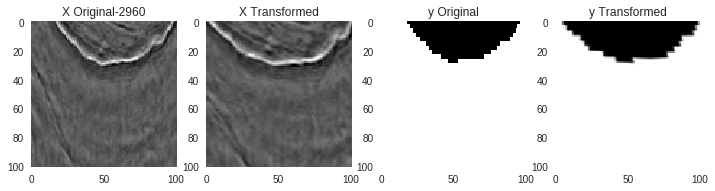

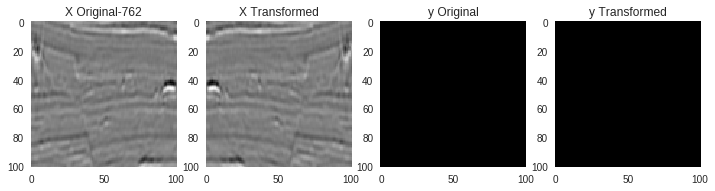

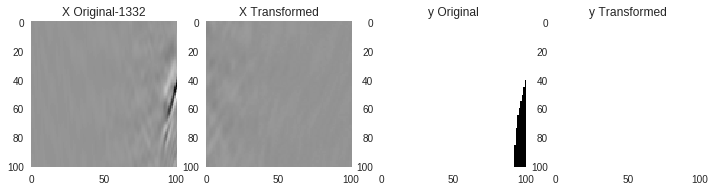

In [22]:
i = 0
for X_batch, y_batch, d_batch, X_id in dataloaders['train']:
    i+=1
    if i>3:
        break
    X_orig = X_train[X_id[0]].squeeze()/255
    X_tsfm = X_batch[0,0].squeeze().cpu().detach().numpy()[13:114,13:114] + X_train_mean_img.squeeze()
    y_orig = y_train[X_id[0]].squeeze()
    y_tsfm = (y_batch[0].squeeze().cpu().detach().numpy())
    plot_img_mask_pred([X_orig, X_tsfm, y_orig, y_tsfm],
                       [f'X Original-{X_id[0]}', 'X Transformed', 'y Original', 'y Transformed'])

In [23]:
X_train.shape

(3200, 101, 101, 1)

### Create a Train Dataloader for sanity check

In [0]:
data_params = {'batch_size': 16,
               'shuffle': False,
               'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train[:16], y_train[:16], depth_train[:16],
                           X_train_mean_img, out_size=128, out_ch=1,
                           transform=None), **data_params)
                           #transform=p.torch_transform()), **data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val[:16], y_val[:16], depth_val[:16], 
                           X_train_mean_img, out_size=128, out_ch=1), **data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}


In [0]:
t = iter(train_dataLoader).__next__()

In [0]:
X_batch, y_batch, d_batch, X_id = t

In [0]:
def train_model(model, dataloaders, criterion1, criterion2, optimizer, scheduler, model_save_name, other_data={}, 
                num_epochs=25, print_every=2, save_model_every=None, save_log_every=None, log=get_logger('SaltNet'), loss2_weight=0):
    #args = locals()
    #args = {k:v.shape if isinstance(v, (torch.Tensor, np.ndarray)) else v for k,v in args.items()}
    #args = {k:v.shape if isinstance(v, (torch.Tensor, np.ndarray)) else v for k,v in args.items()}
    log.info('Start Training...')
    #log.info('Passed parameters: {}'.format(args))

    start = time.time()

    if torch.cuda.is_available():
        model.cuda()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_model = None
    best_iou = 0.0
    all_losses = []
    iter_count = 0
    X_train = other_data['X_train']
    X_val = other_data['X_val']
    y_train = other_data['y_train']
    y_val = other_data['y_val']
    X_train_mean_img = other_data['X_train_mean_img']
    mask_cutoff = 0.

    for epoch in range(1, num_epochs+1):
        log.info('Epoch {}/{}'.format(epoch, num_epochs))
        log.info('-' * 20)
        if save_log_every is not None:
            if (epoch % save_log_every == 0):
                push_log_to_git()
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_loss1 = []
            epoch_loss2 = []
            pred_vs_true_epoch = []

            for X_batch, y_batch, d_batch, X_id in dataloaders[phase]:
                # zero the parameter gradients
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    #y_pred, y_mask_pred = model(X_batch)
                    y_pred = model(X_batch)
                    pred_vs_true_epoch.append([y_pred, y_batch])
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':                        
                        #from boxx import g
                        #g()
                        loss_1 = criterion1(y_pred, y_batch.float())      
                        loss_2 = loss2_weight * criterion2(y_pred, y_batch.float()) 

                        #print(f'loss_pix: {loss_pix}, loss_dice:{loss_dice}')
                        loss = loss_1 + loss_2
                        #loss = loss_pix
                        all_losses.append(loss.item())
                        epoch_loss1.append(loss_1.item())
                        epoch_loss2.append(loss_2.item())
                        
                        loss.backward()
                        optimizer.step()
                        iter_count += 1
                if (phase == 'train') & (iter_count % print_every == 0):
                    iou_batch = calc_mean_iou(y_pred.ge(mask_cutoff), y_batch.float())
                    iou_acc = calc_clf_accuracy(y_pred.ge(mask_cutoff), y_batch.float())

                    log.info('Batch Loss: {:.4f}, Epoch loss_1: {:.4f}, Epoch loss_2: {:.4f}, Batch IOU: {:.4f}, Batch Acc: {:.4f} at iter {}, epoch {}, Time: {}'.format(
                        np.mean(all_losses[-print_every:]), np.mean(epoch_loss1), np.mean(epoch_loss2), iou_batch, iou_acc, iter_count, epoch, timeSince(start))
                    )
                    #print(all_losses)
                    X_orig = X_train[X_id[0]].squeeze()/255
                    X_tsfm = X_batch[0,0].squeeze().cpu().detach().numpy()
                    X_tsfm = transform.resize(X_tsfm, (128, 128), mode='constant', preserve_range=True)
                    X_tsfm = X_tsfm[13:114,13:114] + X_train_mean_img.squeeze()
                    #X_tsfm = X_batch[0][X_batch[0].sum((1,2)).argmax()].squeeze().cpu().detach().numpy()[:101,:101] + X_train_mean_img.squeeze()

                    y_orig = y_train[X_id[0]].squeeze()
                    y_tsfm = (y_batch[0].squeeze().cpu().detach().numpy())
                    y_tsfm_pred =  y_pred[0].squeeze().gt(mask_cutoff)
                    plot_img_mask_pred([X_orig, X_tsfm, y_orig, y_tsfm, y_tsfm_pred],
                                       ['X Original', 'X Transformed', 'y Original', 'y Transformed', 'y Predicted'])

            y_pred_epoch = torch.cat([e[0] for e in pred_vs_true_epoch])
            y_true_epoch = torch.cat([e[1] for e in pred_vs_true_epoch])
            #from boxx import g
            #g()
            mean_iou_epoch = calc_mean_iou(y_pred_epoch.ge(mask_cutoff), y_true_epoch.float())
            mean_acc_epoch = calc_clf_accuracy(y_pred_epoch.ge(mask_cutoff), y_true_epoch.float())
            log.info('{} Mean IOU: {:.4f}, Mean Acc: {:.4f}, Best Val IOU: {:.4f} at epoch {}'.format(phase, mean_iou_epoch, mean_acc_epoch, best_iou, epoch))
            if phase == 'val' and mean_iou_epoch > best_iou:
                best_iou = mean_iou_epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                stats = {'best_iou': best_iou,
                         'all_losses': all_losses,
                         'iter_count': iter_count}
                log.info(save_model_state_to_chunks(epoch, copy.deepcopy(model.state_dict()),
                                                    copy.deepcopy(optimizer.state_dict()),
                                                    copy.deepcopy(scheduler.state_dict()), stats, model_save_name, '.'))
                best_model = (epoch, copy.deepcopy(model.state_dict()),
                                                    copy.deepcopy(optimizer.state_dict()),
                                                    copy.deepcopy(scheduler.state_dict()), stats, model_save_name, '.')
                log.info('Best Val Mean IOU so far: {}'.format(best_iou))
                # Visualize 1 val sample and predictions
                X_orig = X_val[X_id[0]].squeeze()/255
                y_orig = y_val[X_id[0]].squeeze()
                y_pred2 =  y_pred[0].squeeze().gt(mask_cutoff)
                plot_img_mask_pred([X_orig, y_orig, y_pred2],
                                   ['Val X Original', 'Val y Original', 'Val y Predicted'])
        if save_model_every is not None:
            if (epoch % save_model_every == 0) | (epoch == num_epochs-1):
                if (best_model is not None) and (best_iou>0.81):
                    log.info(save_model_state_to_chunks(*best_model))                
                    push_model_to_git(ckp_name=model_save_name)
                    best_model = None
                else:
                    log.info("Skip pushing model to git as there's no improvement")

    # load best model weights
    model.load_state_dict(best_model_wts)
    log.info('-' * 20)
    time_elapsed = time.time() - start
    log.info('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    log.info('Best val IOU: {:4f}'.format(best_iou))

    return model

## Train the model using a small data set to see if it can overfit

In [0]:
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)

Using bilinear for upsampling
Using bilinear for upsampling
Using bilinear for upsampling
Using bilinear for upsampling


In [0]:
#saltnet = resnet34unet(in_ch=3, bilinear=False, pretrained=False)

loss_fn_bce = nn.BCEWithLogitsLoss()
loss_lovasz_hinge = LovaszHingeLoss()

optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

model_save_name = None

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=100, print_every=2, save_model_every=None, save_log_every=None, log=log)

## Train the full with full dataset

In [32]:
log.info('Fine tune with lavasz loss set to 0.3, use more data augmentation, use focal loss instead of bce loss')

07/09/2018 04:57:02 - SaltNet - INFO - Fine tune with lavasz loss set to 0.3, use more data augmentation, use focal loss instead of bce loss


In [33]:
log.info(model_info)

07/09/2018 04:57:04 - SaltNet - INFO - p = Pipeline_Salt()
#p.skew(probability=0.5, magnitude=0.2)
#p.random_distortion(probability=0.5, grid_width=5, grid_height=5, magnitude=3)
#p.rotate(probability=0.5, max_left_rotation=15, max_right_rotation=15)
#p.zoom(probability=0.5, min_factor=1.0, max_factor=1.1)
#p.shear(probability=0.5, max_shear_left=15, max_shear_right=15)
p.flip_left_right(probability=0.5)
#p.flip_top_bottom(probability=0.5)
p.crop_by_size(probability=0.5, width=101, height=101, centre=False)

loss_fn_bce = nn.BCEWithLogitsLoss()
loss_lovasz_hinge = LovaszHingeLoss()

# fine tuning
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)
if torch.cuda.is_available():
  saltnet.cuda()
model_file_suffix = "../salt_net/Unet_bce_loss_lovasz_loss_2018_09_05_23_54_40.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])
optimizer = torch.optim.Adam(saltne

In [0]:
model_info = '''p = Pipeline_Salt()
#p.skew(probability=0.5, magnitude=0.2)
#p.random_distortion(probability=0.5, grid_width=5, grid_height=5, magnitude=3)
#p.rotate(probability=0.5, max_left_rotation=15, max_right_rotation=15)
#p.zoom(probability=0.5, min_factor=1.0, max_factor=1.1)
#p.shear(probability=0.5, max_shear_left=15, max_shear_right=15)
p.flip_left_right(probability=0.5)
#p.flip_top_bottom(probability=0.5)
p.crop_by_size(probability=0.5, width=101, height=101, centre=False)

loss_fn_bce = nn.BCEWithLogitsLoss()
loss_lovasz_hinge = LovaszHingeLoss()

# fine tuning
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)
if torch.cuda.is_available():
  saltnet.cuda()
model_file_suffix = "../salt_net/Unet_bce_loss_lovasz_loss_2018_09_05_23_54_40.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)
optimizer.load_state_dict(model_state_dict['optimizer'])
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
scheduler.load_state_dict(model_state_dict['scheduler'])

model_save_name = f'../salt_net/Unet_bce_loss_lovasz_loss_finetune_{get_current_time_as_fname()}.ckp'
#model_save_name = None
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=100, print_every=50, save_model_every=20, save_log_every=2, log=log, loss2_weight=0.2)'''

In [0]:
p = Pipeline_Salt()
#p.skew(probability=0.5, magnitude=0.2)
#p.random_distortion(probability=0.5, grid_width=5, grid_height=5, magnitude=3)
#p.rotate(probability=0.5, max_left_rotation=15, max_right_rotation=15)
#p.zoom(probability=0.5, min_factor=1.0, max_factor=1.1)
#p.shear(probability=0.5, max_shear_left=15, max_shear_right=15)
p.flip_left_right(probability=0.5)
#p.flip_top_bottom(probability=0.5)
p.crop_by_size(probability=0.5, width=101, height=101, centre=False)


In [0]:
data_params = {'batch_size': 32,
               'shuffle': True,
               'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           X_train_mean_img, out_size=128,  out_ch=1,
                           transform=p.torch_transform()), **data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           X_train_mean_img, out_size=128, out_ch=1), **data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

In [0]:
loss_fn_bce = nn.BCEWithLogitsLoss()
loss_lovasz_hinge = LovaszHingeLoss()

Using bilinear for upsampling
Using bilinear for upsampling
Using bilinear for upsampling
Using bilinear for upsampling


07/09/2018 04:57:54 - SaltNet - INFO - ../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp
07/09/2018 04:57:54 - SaltNet - INFO - Start Training...
07/09/2018 04:57:54 - SaltNet - INFO - Epoch 1/150
07/09/2018 04:57:54 - SaltNet - INFO - --------------------
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
07/09/2018 04:59:10 - SaltNet - INFO - Batch Loss: 0.2577, Epoch loss_1: 0.1266, Epoch loss_2: 0.1312, Batch IOU: 0.7875, Batch Acc: 0.9548 at iter 50, epoch 1, Time: 1m 16s


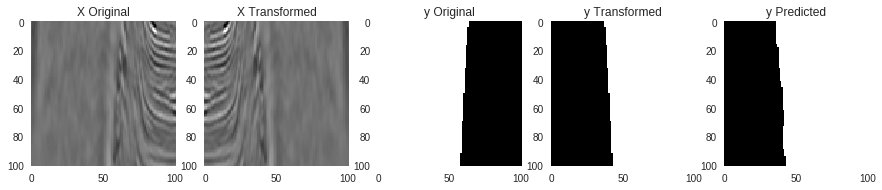

07/09/2018 05:00:27 - SaltNet - INFO - Batch Loss: 0.2462, Epoch loss_1: 0.1225, Epoch loss_2: 0.1295, Batch IOU: 0.8687, Batch Acc: 0.9745 at iter 100, epoch 1, Time: 2m 33s


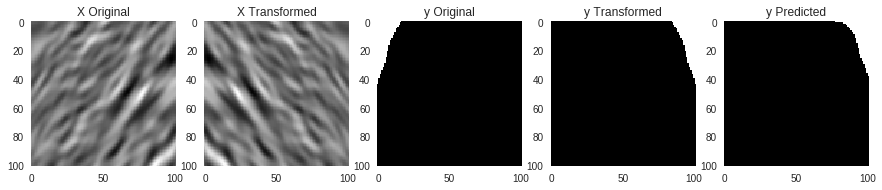

07/09/2018 05:00:28 - SaltNet - INFO - train Mean IOU: 0.8181, Mean Acc: 0.9569, Best Val IOU: 0.0000 at epoch 1
07/09/2018 05:00:40 - SaltNet - INFO - val Mean IOU: 0.8108, Mean Acc: 0.9544, Best Val IOU: 0.0000 at epoch 1
07/09/2018 05:00:40 - SaltNet - INFO - ['../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-1-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-2-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-3-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-4-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-5-Of-5']
07/09/2018 05:00:40 - SaltNet - INFO - Best Val Mean IOU so far: 0.8107500000000001


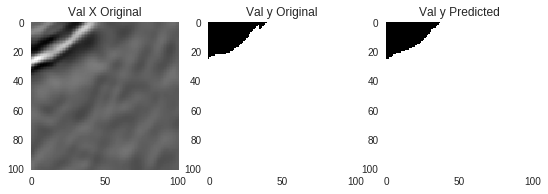

07/09/2018 05:00:41 - SaltNet - INFO - Epoch 2/150
07/09/2018 05:00:41 - SaltNet - INFO - --------------------
07/09/2018 05:00:41 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master cc1cbd0] Pushing logs to git
 2 files changed, 56 insertions(+)
 create mode 100644 logs/SaltNet_2018_09_07_14h.log
Counting objects: 5, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 1.81 KiB | 1.81 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   fe1291e..cc1cbd0  master -> master


07/09/2018 05:02:15 - SaltNet - INFO - Batch Loss: 0.2471, Epoch loss_1: 0.1144, Epoch loss_2: 0.1327, Batch IOU: 0.8750, Batch Acc: 0.9824 at iter 150, epoch 2, Time: 4m 21s


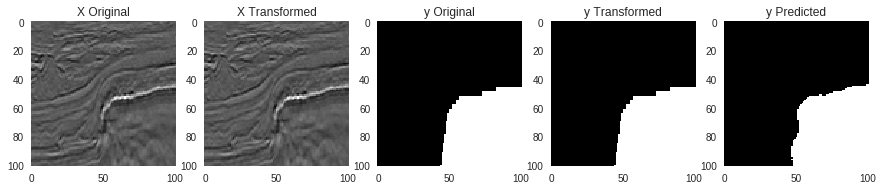

07/09/2018 05:03:32 - SaltNet - INFO - Batch Loss: 0.2323, Epoch loss_1: 0.1131, Epoch loss_2: 0.1266, Batch IOU: 0.8344, Batch Acc: 0.9294 at iter 200, epoch 2, Time: 5m 38s


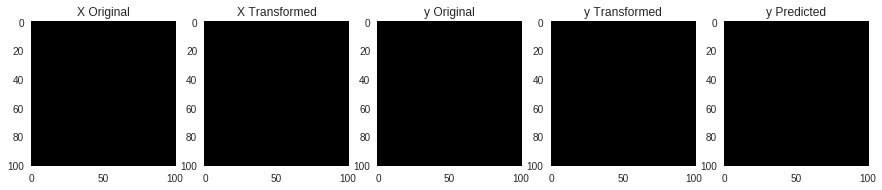

07/09/2018 05:03:34 - SaltNet - INFO - train Mean IOU: 0.8233, Mean Acc: 0.9602, Best Val IOU: 0.8108 at epoch 2
07/09/2018 05:03:45 - SaltNet - INFO - val Mean IOU: 0.8119, Mean Acc: 0.9538, Best Val IOU: 0.8108 at epoch 2
07/09/2018 05:03:46 - SaltNet - INFO - ['../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-1-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-2-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-3-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-4-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-5-Of-5']
07/09/2018 05:03:46 - SaltNet - INFO - Best Val Mean IOU so far: 0.811875


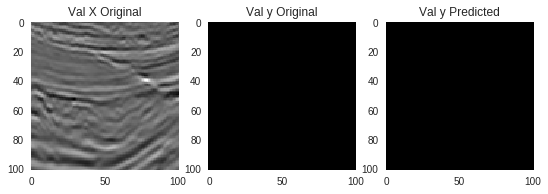

07/09/2018 05:03:46 - SaltNet - INFO - Epoch 3/150
07/09/2018 05:03:46 - SaltNet - INFO - --------------------
07/09/2018 05:05:03 - SaltNet - INFO - Batch Loss: 0.2339, Epoch loss_1: 0.1095, Epoch loss_2: 0.1243, Batch IOU: 0.8125, Batch Acc: 0.9666 at iter 250, epoch 3, Time: 7m 9s


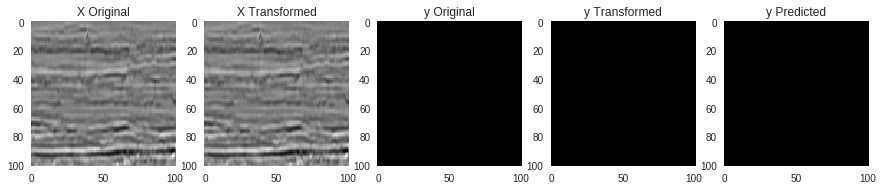

07/09/2018 05:06:20 - SaltNet - INFO - Batch Loss: 0.2477, Epoch loss_1: 0.1115, Epoch loss_2: 0.1293, Batch IOU: 0.8812, Batch Acc: 0.9249 at iter 300, epoch 3, Time: 8m 26s


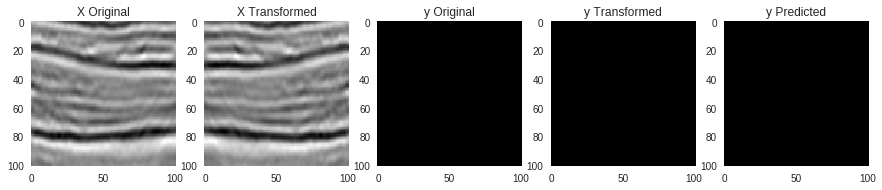

07/09/2018 05:06:21 - SaltNet - INFO - train Mean IOU: 0.8227, Mean Acc: 0.9600, Best Val IOU: 0.8119 at epoch 3
07/09/2018 05:06:32 - SaltNet - INFO - val Mean IOU: 0.8113, Mean Acc: 0.9538, Best Val IOU: 0.8119 at epoch 3
07/09/2018 05:06:32 - SaltNet - INFO - Epoch 4/150
07/09/2018 05:06:32 - SaltNet - INFO - --------------------
07/09/2018 05:06:32 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master e6fdfa6] Pushing logs to git
 1 file changed, 15 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 733 bytes | 733.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   cc1cbd0..e6fdfa6  master -> master


07/09/2018 05:08:05 - SaltNet - INFO - Batch Loss: 0.2316, Epoch loss_1: 0.1052, Epoch loss_2: 0.1263, Batch IOU: 0.8094, Batch Acc: 0.9488 at iter 350, epoch 4, Time: 10m 11s


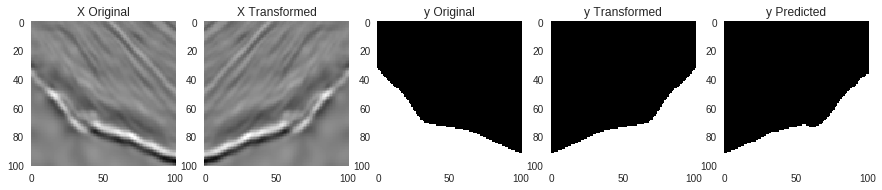

07/09/2018 05:09:23 - SaltNet - INFO - Batch Loss: 0.2396, Epoch loss_1: 0.1092, Epoch loss_2: 0.1264, Batch IOU: 0.8156, Batch Acc: 0.9608 at iter 400, epoch 4, Time: 11m 29s


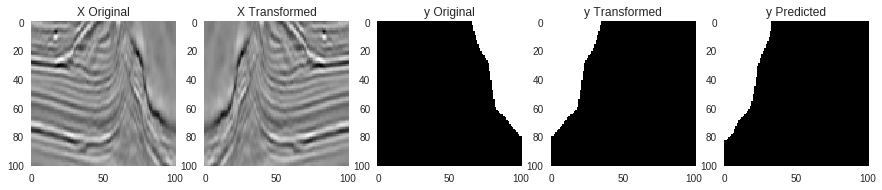

07/09/2018 05:09:24 - SaltNet - INFO - train Mean IOU: 0.8243, Mean Acc: 0.9610, Best Val IOU: 0.8119 at epoch 4
07/09/2018 05:09:36 - SaltNet - INFO - val Mean IOU: 0.8049, Mean Acc: 0.9549, Best Val IOU: 0.8119 at epoch 4
07/09/2018 05:09:36 - SaltNet - INFO - Epoch 5/150
07/09/2018 05:09:36 - SaltNet - INFO - --------------------
07/09/2018 05:10:52 - SaltNet - INFO - Batch Loss: 0.2438, Epoch loss_1: 0.1090, Epoch loss_2: 0.1347, Batch IOU: 0.6500, Batch Acc: 0.8937 at iter 450, epoch 5, Time: 12m 58s


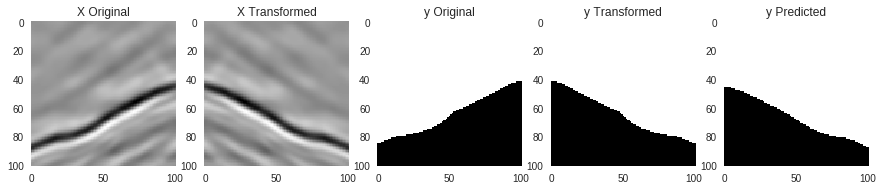

07/09/2018 05:12:10 - SaltNet - INFO - Batch Loss: 0.2347, Epoch loss_1: 0.1111, Epoch loss_2: 0.1281, Batch IOU: 0.9313, Batch Acc: 0.9874 at iter 500, epoch 5, Time: 14m 16s


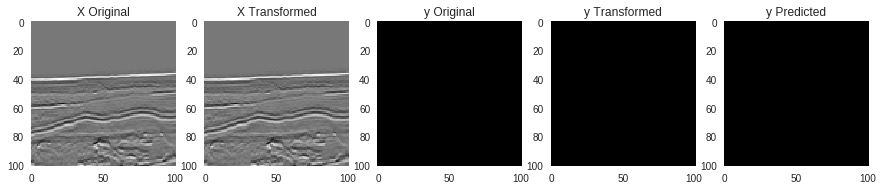

07/09/2018 05:12:11 - SaltNet - INFO - train Mean IOU: 0.8221, Mean Acc: 0.9598, Best Val IOU: 0.8119 at epoch 5
07/09/2018 05:12:22 - SaltNet - INFO - val Mean IOU: 0.8075, Mean Acc: 0.9551, Best Val IOU: 0.8119 at epoch 5
07/09/2018 05:12:22 - SaltNet - INFO - Epoch 6/150
07/09/2018 05:12:22 - SaltNet - INFO - --------------------
07/09/2018 05:12:22 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master 3bc2b1c] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 720 bytes | 720.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   e6fdfa6..3bc2b1c  master -> master


07/09/2018 05:13:56 - SaltNet - INFO - Batch Loss: 0.2369, Epoch loss_1: 0.1080, Epoch loss_2: 0.1289, Batch IOU: 0.8188, Batch Acc: 0.9483 at iter 550, epoch 6, Time: 16m 2s


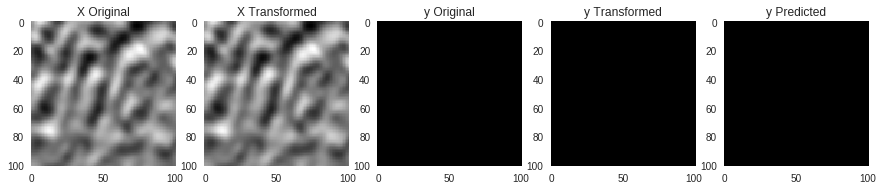

07/09/2018 05:15:14 - SaltNet - INFO - Batch Loss: 0.2227, Epoch loss_1: 0.1051, Epoch loss_2: 0.1247, Batch IOU: 0.7562, Batch Acc: 0.9621 at iter 600, epoch 6, Time: 17m 20s


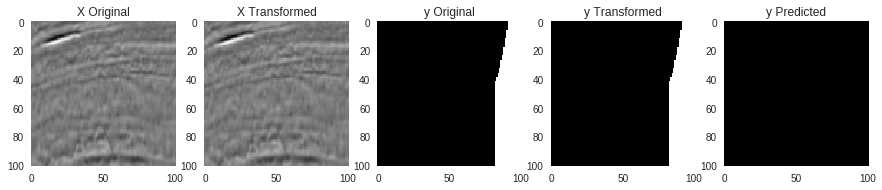

07/09/2018 05:15:15 - SaltNet - INFO - train Mean IOU: 0.8257, Mean Acc: 0.9615, Best Val IOU: 0.8119 at epoch 6
07/09/2018 05:15:26 - SaltNet - INFO - val Mean IOU: 0.8036, Mean Acc: 0.9555, Best Val IOU: 0.8119 at epoch 6
07/09/2018 05:15:26 - SaltNet - INFO - Epoch 7/150
07/09/2018 05:15:26 - SaltNet - INFO - --------------------
07/09/2018 05:16:43 - SaltNet - INFO - Batch Loss: 0.2399, Epoch loss_1: 0.1135, Epoch loss_2: 0.1265, Batch IOU: 0.7500, Batch Acc: 0.9771 at iter 650, epoch 7, Time: 18m 49s


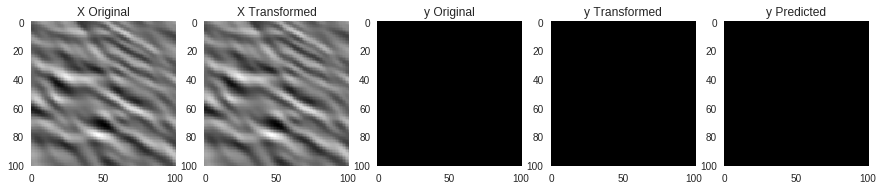

07/09/2018 05:18:00 - SaltNet - INFO - Batch Loss: 0.2145, Epoch loss_1: 0.1041, Epoch loss_2: 0.1231, Batch IOU: 0.7656, Batch Acc: 0.9339 at iter 700, epoch 7, Time: 20m 6s


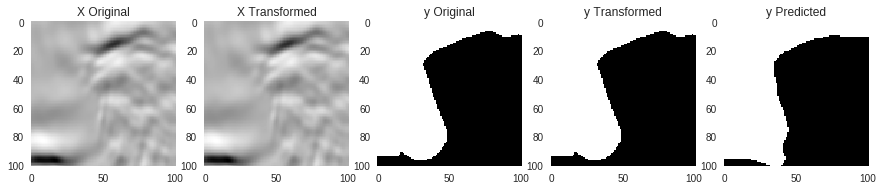

07/09/2018 05:18:01 - SaltNet - INFO - train Mean IOU: 0.8269, Mean Acc: 0.9619, Best Val IOU: 0.8119 at epoch 7
07/09/2018 05:18:13 - SaltNet - INFO - val Mean IOU: 0.8050, Mean Acc: 0.9556, Best Val IOU: 0.8119 at epoch 7
07/09/2018 05:18:13 - SaltNet - INFO - Epoch 8/150
07/09/2018 05:18:13 - SaltNet - INFO - --------------------
07/09/2018 05:18:13 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master 7c651f2] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 677 bytes | 677.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   3bc2b1c..7c651f2  master -> master


07/09/2018 05:19:47 - SaltNet - INFO - Batch Loss: 0.2331, Epoch loss_1: 0.1087, Epoch loss_2: 0.1244, Batch IOU: 0.7500, Batch Acc: 0.9647 at iter 750, epoch 8, Time: 21m 53s


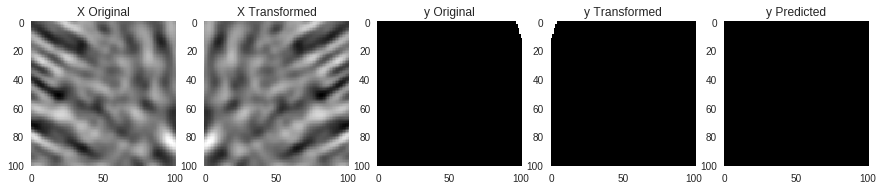

07/09/2018 05:21:04 - SaltNet - INFO - Batch Loss: 0.2339, Epoch loss_1: 0.1072, Epoch loss_2: 0.1263, Batch IOU: 0.8187, Batch Acc: 0.9739 at iter 800, epoch 8, Time: 23m 10s


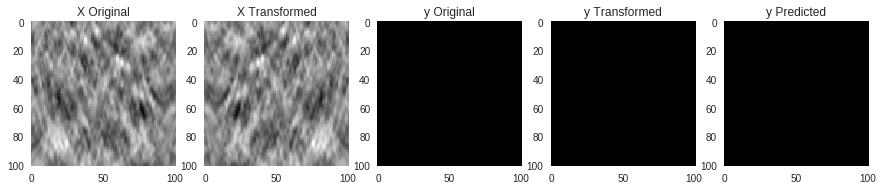

07/09/2018 05:21:06 - SaltNet - INFO - train Mean IOU: 0.8245, Mean Acc: 0.9604, Best Val IOU: 0.8119 at epoch 8
07/09/2018 05:21:17 - SaltNet - INFO - val Mean IOU: 0.8128, Mean Acc: 0.9544, Best Val IOU: 0.8119 at epoch 8
07/09/2018 05:21:18 - SaltNet - INFO - ['../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-1-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-2-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-3-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-4-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-5-Of-5']
07/09/2018 05:21:18 - SaltNet - INFO - Best Val Mean IOU so far: 0.8127500000000001


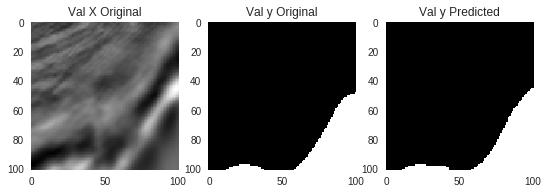

07/09/2018 05:21:18 - SaltNet - INFO - Epoch 9/150
07/09/2018 05:21:18 - SaltNet - INFO - --------------------
07/09/2018 05:22:35 - SaltNet - INFO - Batch Loss: 0.2212, Epoch loss_1: 0.1041, Epoch loss_2: 0.1171, Batch IOU: 0.8625, Batch Acc: 0.9260 at iter 850, epoch 9, Time: 24m 41s


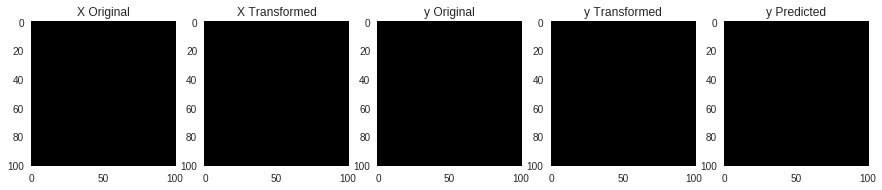

07/09/2018 05:23:52 - SaltNet - INFO - Batch Loss: 0.2334, Epoch loss_1: 0.1051, Epoch loss_2: 0.1222, Batch IOU: 0.8375, Batch Acc: 0.9474 at iter 900, epoch 9, Time: 25m 58s


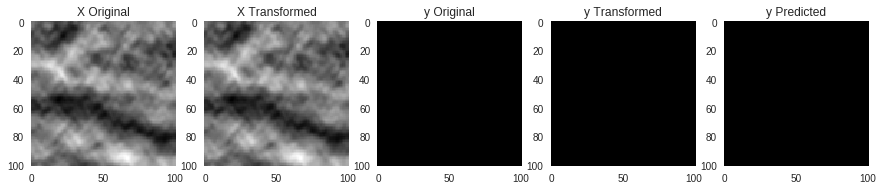

07/09/2018 05:23:53 - SaltNet - INFO - train Mean IOU: 0.8289, Mean Acc: 0.9616, Best Val IOU: 0.8128 at epoch 9
07/09/2018 05:24:05 - SaltNet - INFO - val Mean IOU: 0.8063, Mean Acc: 0.9542, Best Val IOU: 0.8128 at epoch 9
07/09/2018 05:24:05 - SaltNet - INFO - Epoch 10/150
07/09/2018 05:24:05 - SaltNet - INFO - --------------------
07/09/2018 05:24:05 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master acec702] Pushing logs to git
 1 file changed, 15 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 719 bytes | 719.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   7c651f2..acec702  master -> master


07/09/2018 05:25:36 - SaltNet - INFO - Batch Loss: 0.2285, Epoch loss_1: 0.1061, Epoch loss_2: 0.1225, Batch IOU: 0.7844, Batch Acc: 0.9326 at iter 950, epoch 10, Time: 27m 42s


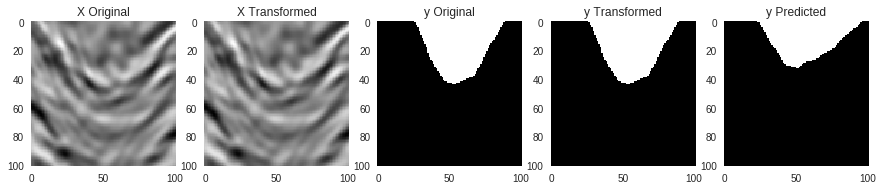

07/09/2018 05:26:53 - SaltNet - INFO - Batch Loss: 0.2168, Epoch loss_1: 0.1035, Epoch loss_2: 0.1192, Batch IOU: 0.7781, Batch Acc: 0.9268 at iter 1000, epoch 10, Time: 28m 59s


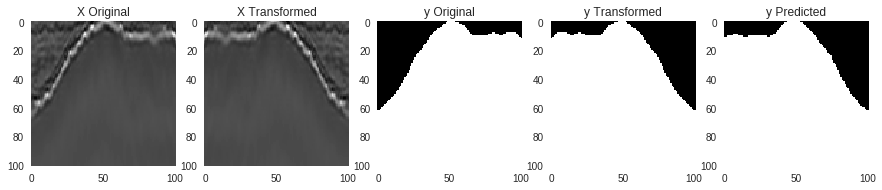

07/09/2018 05:26:54 - SaltNet - INFO - train Mean IOU: 0.8323, Mean Acc: 0.9626, Best Val IOU: 0.8128 at epoch 10
07/09/2018 05:27:05 - SaltNet - INFO - val Mean IOU: 0.8083, Mean Acc: 0.9563, Best Val IOU: 0.8128 at epoch 10
07/09/2018 05:27:05 - SaltNet - INFO - Epoch 11/150
07/09/2018 05:27:05 - SaltNet - INFO - --------------------
07/09/2018 05:28:22 - SaltNet - INFO - Batch Loss: 0.2098, Epoch loss_1: 0.0963, Epoch loss_2: 0.1135, Batch IOU: 0.8344, Batch Acc: 0.9790 at iter 1050, epoch 11, Time: 30m 28s


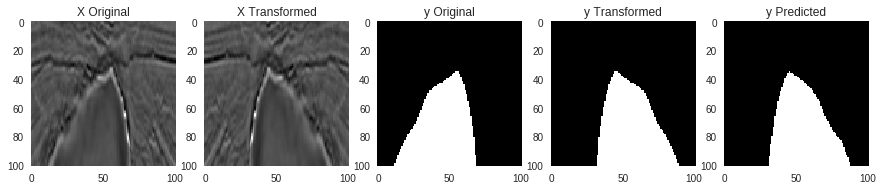

07/09/2018 05:29:40 - SaltNet - INFO - Batch Loss: 0.2379, Epoch loss_1: 0.1017, Epoch loss_2: 0.1222, Batch IOU: 0.8000, Batch Acc: 0.9275 at iter 1100, epoch 11, Time: 31m 46s


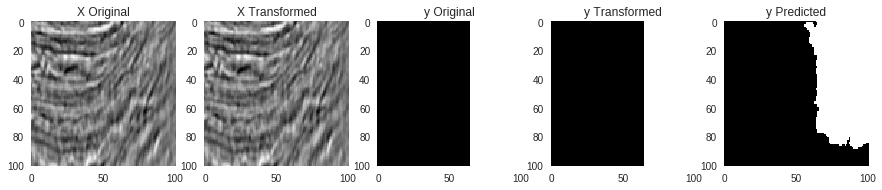

07/09/2018 05:29:41 - SaltNet - INFO - train Mean IOU: 0.8292, Mean Acc: 0.9630, Best Val IOU: 0.8128 at epoch 11
07/09/2018 05:29:52 - SaltNet - INFO - val Mean IOU: 0.8058, Mean Acc: 0.9545, Best Val IOU: 0.8128 at epoch 11
07/09/2018 05:29:52 - SaltNet - INFO - Epoch 12/150
07/09/2018 05:29:52 - SaltNet - INFO - --------------------
07/09/2018 05:29:52 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master 9ab93b7] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 718 bytes | 718.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   acec702..9ab93b7  master -> master


07/09/2018 05:31:25 - SaltNet - INFO - Batch Loss: 0.2172, Epoch loss_1: 0.0986, Epoch loss_2: 0.1186, Batch IOU: 0.8844, Batch Acc: 0.9796 at iter 1150, epoch 12, Time: 33m 30s


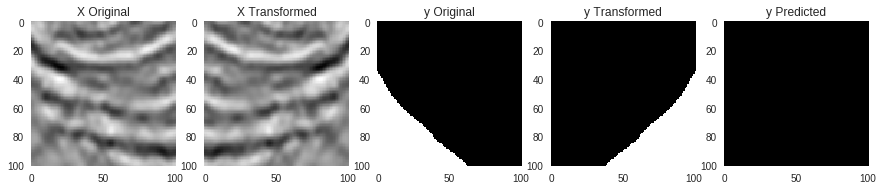

07/09/2018 05:32:42 - SaltNet - INFO - Batch Loss: 0.2362, Epoch loss_1: 0.1040, Epoch loss_2: 0.1227, Batch IOU: 0.7188, Batch Acc: 0.9469 at iter 1200, epoch 12, Time: 34m 48s


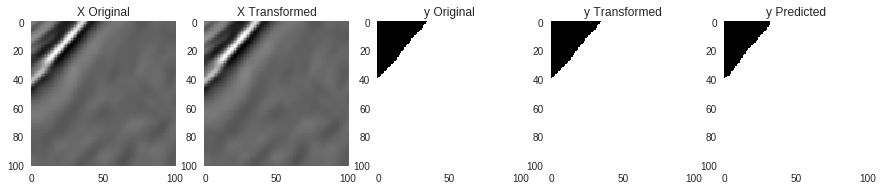

07/09/2018 05:32:43 - SaltNet - INFO - train Mean IOU: 0.8287, Mean Acc: 0.9621, Best Val IOU: 0.8128 at epoch 12
07/09/2018 05:32:54 - SaltNet - INFO - val Mean IOU: 0.8114, Mean Acc: 0.9555, Best Val IOU: 0.8128 at epoch 12
07/09/2018 05:32:54 - SaltNet - INFO - Epoch 13/150
07/09/2018 05:32:54 - SaltNet - INFO - --------------------
07/09/2018 05:34:11 - SaltNet - INFO - Batch Loss: 0.2228, Epoch loss_1: 0.1055, Epoch loss_2: 0.1173, Batch IOU: 0.8781, Batch Acc: 0.9750 at iter 1250, epoch 13, Time: 36m 17s


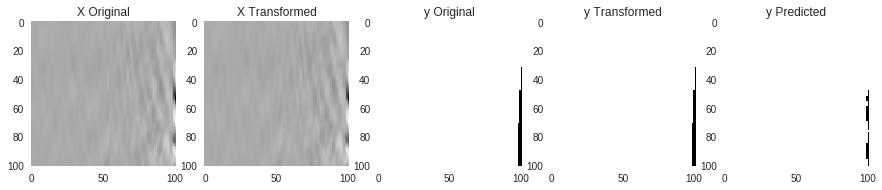

07/09/2018 05:35:28 - SaltNet - INFO - Batch Loss: 0.2230, Epoch loss_1: 0.1030, Epoch loss_2: 0.1199, Batch IOU: 0.7750, Batch Acc: 0.8994 at iter 1300, epoch 13, Time: 37m 34s


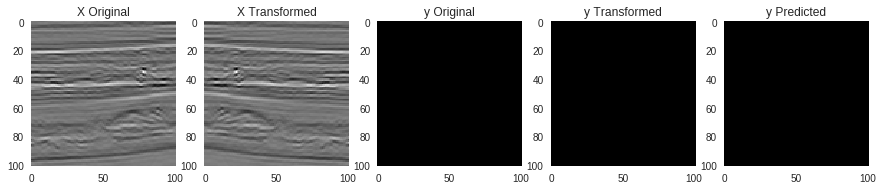

07/09/2018 05:35:29 - SaltNet - INFO - train Mean IOU: 0.8294, Mean Acc: 0.9621, Best Val IOU: 0.8128 at epoch 13
07/09/2018 05:35:41 - SaltNet - INFO - val Mean IOU: 0.8080, Mean Acc: 0.9550, Best Val IOU: 0.8128 at epoch 13
07/09/2018 05:35:41 - SaltNet - INFO - Epoch 14/150
07/09/2018 05:35:41 - SaltNet - INFO - --------------------
07/09/2018 05:35:41 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master cc4536a] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 719 bytes | 719.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   9ab93b7..cc4536a  master -> master


07/09/2018 05:37:13 - SaltNet - INFO - Batch Loss: 0.2138, Epoch loss_1: 0.0965, Epoch loss_2: 0.1173, Batch IOU: 0.7875, Batch Acc: 0.9820 at iter 1350, epoch 14, Time: 39m 19s


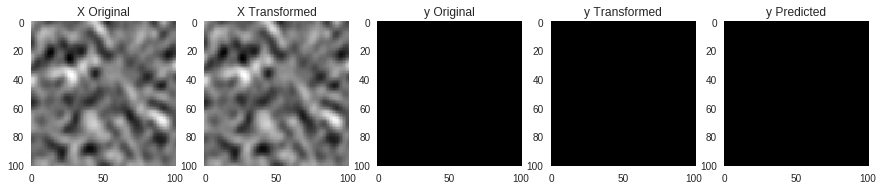

07/09/2018 05:38:30 - SaltNet - INFO - Batch Loss: 0.2255, Epoch loss_1: 0.0996, Epoch loss_2: 0.1200, Batch IOU: 0.7844, Batch Acc: 0.9567 at iter 1400, epoch 14, Time: 40m 36s


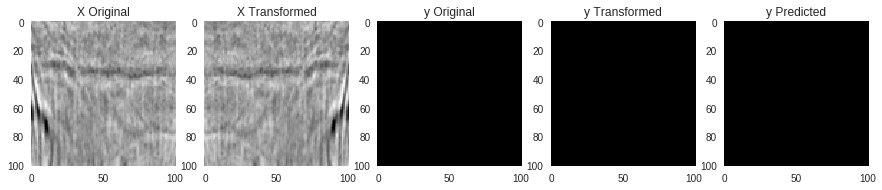

07/09/2018 05:38:32 - SaltNet - INFO - train Mean IOU: 0.8315, Mean Acc: 0.9627, Best Val IOU: 0.8128 at epoch 14
07/09/2018 05:38:43 - SaltNet - INFO - val Mean IOU: 0.8105, Mean Acc: 0.9565, Best Val IOU: 0.8128 at epoch 14
07/09/2018 05:38:43 - SaltNet - INFO - Epoch 15/150
07/09/2018 05:38:43 - SaltNet - INFO - --------------------
07/09/2018 05:40:00 - SaltNet - INFO - Batch Loss: 0.2116, Epoch loss_1: 0.0945, Epoch loss_2: 0.1171, Batch IOU: 0.8031, Batch Acc: 0.9756 at iter 1450, epoch 15, Time: 42m 6s


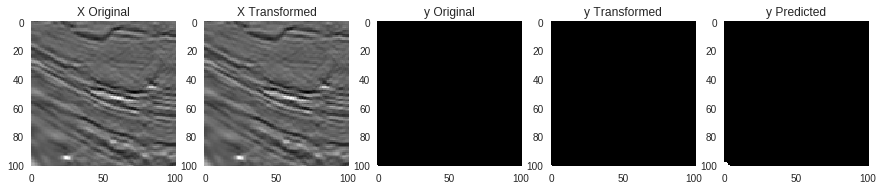

07/09/2018 05:41:17 - SaltNet - INFO - Batch Loss: 0.2312, Epoch loss_1: 0.0995, Epoch loss_2: 0.1218, Batch IOU: 0.9219, Batch Acc: 0.9836 at iter 1500, epoch 15, Time: 43m 23s


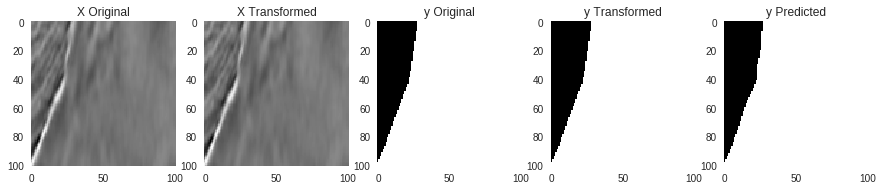

07/09/2018 05:41:18 - SaltNet - INFO - train Mean IOU: 0.8283, Mean Acc: 0.9629, Best Val IOU: 0.8128 at epoch 15
07/09/2018 05:41:29 - SaltNet - INFO - val Mean IOU: 0.8154, Mean Acc: 0.9568, Best Val IOU: 0.8128 at epoch 15
07/09/2018 05:41:30 - SaltNet - INFO - ['../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-1-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-2-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-3-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-4-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-5-Of-5']
07/09/2018 05:41:30 - SaltNet - INFO - Best Val Mean IOU so far: 0.8153750000000001


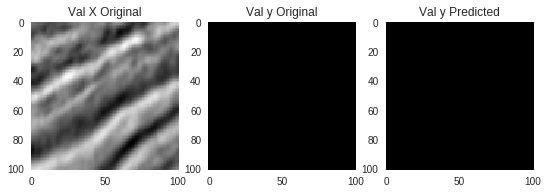

07/09/2018 05:41:30 - SaltNet - INFO - Epoch 16/150
07/09/2018 05:41:30 - SaltNet - INFO - --------------------
07/09/2018 05:41:30 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master 08ddc1c] Pushing logs to git
 1 file changed, 15 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 727 bytes | 727.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   cc4536a..08ddc1c  master -> master


07/09/2018 05:43:03 - SaltNet - INFO - Batch Loss: 0.2244, Epoch loss_1: 0.1037, Epoch loss_2: 0.1207, Batch IOU: 0.8969, Batch Acc: 0.9563 at iter 1550, epoch 16, Time: 45m 9s


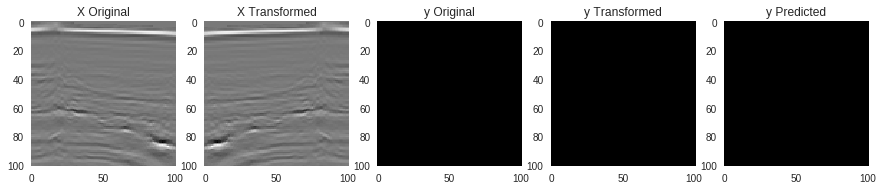

07/09/2018 05:44:20 - SaltNet - INFO - Batch Loss: 0.2100, Epoch loss_1: 0.0992, Epoch loss_2: 0.1181, Batch IOU: 0.8406, Batch Acc: 0.9816 at iter 1600, epoch 16, Time: 46m 26s


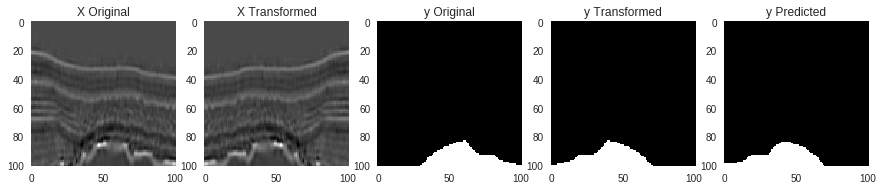

07/09/2018 05:44:21 - SaltNet - INFO - train Mean IOU: 0.8335, Mean Acc: 0.9638, Best Val IOU: 0.8154 at epoch 16
07/09/2018 05:44:32 - SaltNet - INFO - val Mean IOU: 0.8120, Mean Acc: 0.9563, Best Val IOU: 0.8154 at epoch 16
07/09/2018 05:44:32 - SaltNet - INFO - Epoch 17/150
07/09/2018 05:44:32 - SaltNet - INFO - --------------------
07/09/2018 05:45:49 - SaltNet - INFO - Batch Loss: 0.2220, Epoch loss_1: 0.1018, Epoch loss_2: 0.1202, Batch IOU: 0.8969, Batch Acc: 0.9592 at iter 1650, epoch 17, Time: 47m 55s


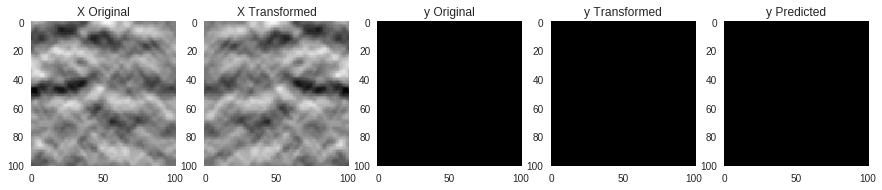

07/09/2018 05:47:06 - SaltNet - INFO - Batch Loss: 0.2116, Epoch loss_1: 0.0976, Epoch loss_2: 0.1192, Batch IOU: 0.7625, Batch Acc: 0.9434 at iter 1700, epoch 17, Time: 49m 12s


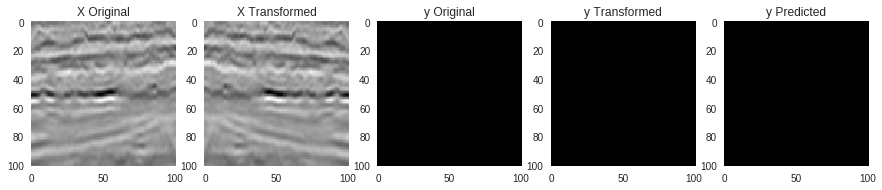

07/09/2018 05:47:07 - SaltNet - INFO - train Mean IOU: 0.8327, Mean Acc: 0.9630, Best Val IOU: 0.8154 at epoch 17
07/09/2018 05:47:19 - SaltNet - INFO - val Mean IOU: 0.8055, Mean Acc: 0.9540, Best Val IOU: 0.8154 at epoch 17
07/09/2018 05:47:19 - SaltNet - INFO - Epoch 18/150
07/09/2018 05:47:19 - SaltNet - INFO - --------------------
07/09/2018 05:47:19 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master d243d8c] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 721 bytes | 721.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   08ddc1c..d243d8c  master -> master


07/09/2018 05:48:50 - SaltNet - INFO - Batch Loss: 0.2124, Epoch loss_1: 0.0965, Epoch loss_2: 0.1159, Batch IOU: 0.8656, Batch Acc: 0.9772 at iter 1750, epoch 18, Time: 50m 56s


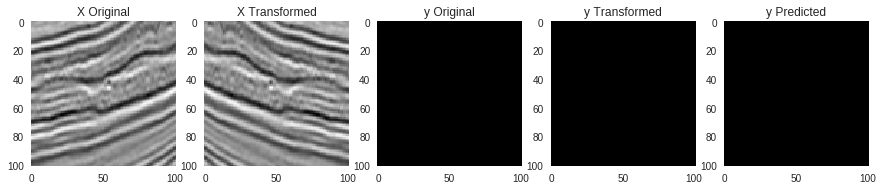

07/09/2018 05:50:08 - SaltNet - INFO - Batch Loss: 0.2200, Epoch loss_1: 0.0990, Epoch loss_2: 0.1172, Batch IOU: 0.8781, Batch Acc: 0.9749 at iter 1800, epoch 18, Time: 52m 14s


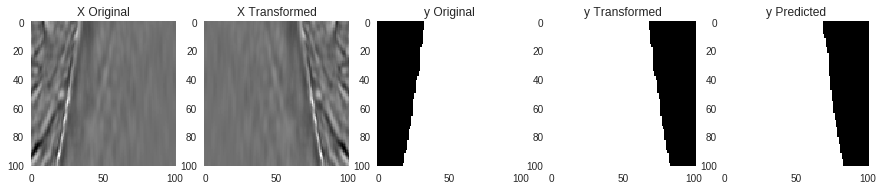

07/09/2018 05:50:09 - SaltNet - INFO - train Mean IOU: 0.8338, Mean Acc: 0.9634, Best Val IOU: 0.8154 at epoch 18
07/09/2018 05:50:21 - SaltNet - INFO - val Mean IOU: 0.8118, Mean Acc: 0.9555, Best Val IOU: 0.8154 at epoch 18
07/09/2018 05:50:21 - SaltNet - INFO - Epoch 19/150
07/09/2018 05:50:21 - SaltNet - INFO - --------------------
07/09/2018 05:51:37 - SaltNet - INFO - Batch Loss: 0.1983, Epoch loss_1: 0.0894, Epoch loss_2: 0.1089, Batch IOU: 0.9062, Batch Acc: 0.9890 at iter 1850, epoch 19, Time: 53m 43s


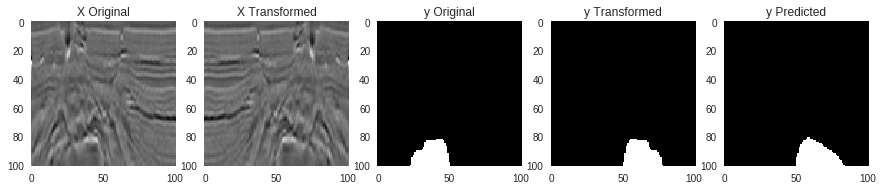

07/09/2018 05:52:55 - SaltNet - INFO - Batch Loss: 0.2273, Epoch loss_1: 0.0953, Epoch loss_2: 0.1174, Batch IOU: 0.9062, Batch Acc: 0.9891 at iter 1900, epoch 19, Time: 55m 1s


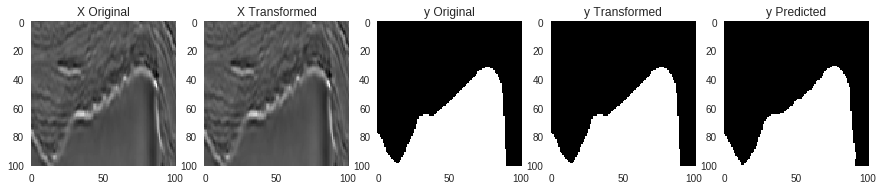

07/09/2018 05:52:56 - SaltNet - INFO - train Mean IOU: 0.8343, Mean Acc: 0.9643, Best Val IOU: 0.8154 at epoch 19
07/09/2018 05:53:07 - SaltNet - INFO - val Mean IOU: 0.8093, Mean Acc: 0.9553, Best Val IOU: 0.8154 at epoch 19
07/09/2018 05:53:07 - SaltNet - INFO - Epoch 20/150
07/09/2018 05:53:07 - SaltNet - INFO - --------------------
07/09/2018 05:53:07 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master 26f86a1] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 706 bytes | 706.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   d243d8c..26f86a1  master -> master


07/09/2018 05:54:41 - SaltNet - INFO - Batch Loss: 0.2182, Epoch loss_1: 0.0997, Epoch loss_2: 0.1185, Batch IOU: 0.9031, Batch Acc: 0.9907 at iter 1950, epoch 20, Time: 56m 46s


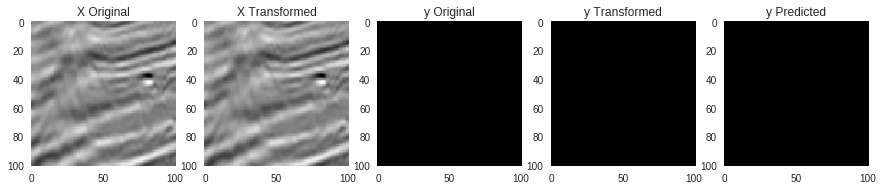

07/09/2018 05:55:58 - SaltNet - INFO - Batch Loss: 0.2085, Epoch loss_1: 0.0971, Epoch loss_2: 0.1163, Batch IOU: 0.8688, Batch Acc: 0.9806 at iter 2000, epoch 20, Time: 58m 4s


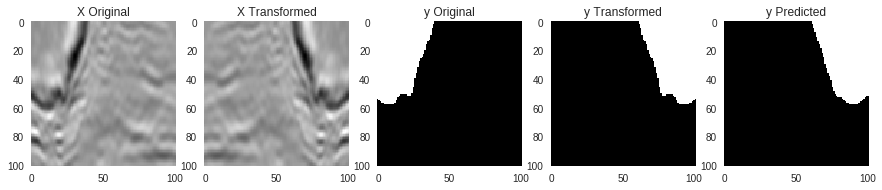

07/09/2018 05:55:59 - SaltNet - INFO - train Mean IOU: 0.8366, Mean Acc: 0.9646, Best Val IOU: 0.8154 at epoch 20
07/09/2018 05:56:10 - SaltNet - INFO - val Mean IOU: 0.8043, Mean Acc: 0.9526, Best Val IOU: 0.8154 at epoch 20
07/09/2018 05:56:11 - SaltNet - INFO - ['../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-1-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-2-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-3-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-4-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-5-Of-5']
07/09/2018 05:56:11 - SaltNet - INFO - Pushing model state to git.


/content/salt_net
[master 3e04315] save model state.
 11 files changed, 6 insertions(+)
 create mode 100644 Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-1-Of-5
 create mode 100644 Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-2-Of-5
 create mode 100644 Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-3-Of-5
 create mode 100644 Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-4-Of-5
 create mode 100644 Unet_bce_loss_lovasz_loss_finetune_2018_09_07_14_57_54.ckp-chunk-5-Of-5
 create mode 100644 Unet_focal_loss_lovasz_loss_finetune_2018_09_07_10_15_48.ckp-chunk-1-Of-5
 create mode 100644 Unet_focal_loss_lovasz_loss_finetune_2018_09_07_10_15_48.ckp-chunk-2-Of-5
 create mode 100644 Unet_focal_loss_lovasz_loss_finetune_2018_09_07_10_15_48.ckp-chunk-3-Of-5
 create mode 100644 Unet_focal_loss_lovasz_loss_finetune_2018_09_07_10_15_48.ckp-chunk-4-Of-5
 create mode 100644 Unet_focal_loss_lovasz_loss_finetune_2018_09_07_10_15_48

07/09/2018 05:58:00 - SaltNet - INFO - Epoch 21/150
07/09/2018 05:58:00 - SaltNet - INFO - --------------------
07/09/2018 05:59:16 - SaltNet - INFO - Batch Loss: 0.2130, Epoch loss_1: 0.0971, Epoch loss_2: 0.1160, Batch IOU: 0.8125, Batch Acc: 0.9819 at iter 2050, epoch 21, Time: 61m 22s


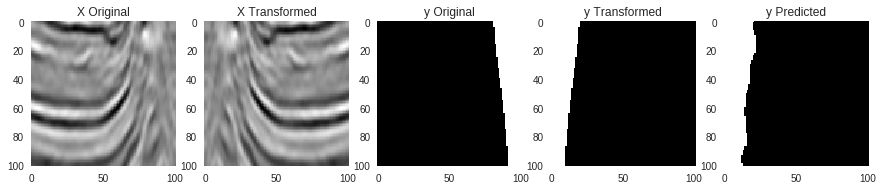

07/09/2018 06:00:34 - SaltNet - INFO - Batch Loss: 0.2181, Epoch loss_1: 0.0968, Epoch loss_2: 0.1188, Batch IOU: 0.8406, Batch Acc: 0.9541 at iter 2100, epoch 21, Time: 62m 40s


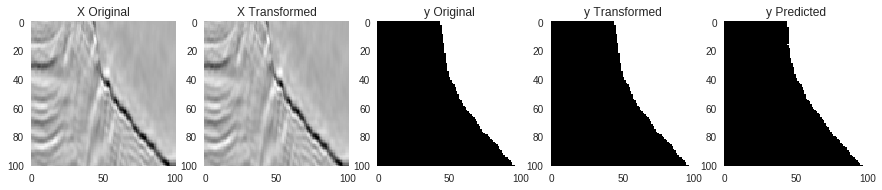

07/09/2018 06:00:35 - SaltNet - INFO - train Mean IOU: 0.8339, Mean Acc: 0.9638, Best Val IOU: 0.8154 at epoch 21
07/09/2018 06:00:46 - SaltNet - INFO - val Mean IOU: 0.8089, Mean Acc: 0.9553, Best Val IOU: 0.8154 at epoch 21
07/09/2018 06:00:46 - SaltNet - INFO - Epoch 22/150
07/09/2018 06:00:46 - SaltNet - INFO - --------------------
07/09/2018 06:00:46 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master f3d8b52] Pushing logs to git
 1 file changed, 9 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 576 bytes | 576.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   3e04315..f3d8b52  master -> master


07/09/2018 06:02:19 - SaltNet - INFO - Batch Loss: 0.2197, Epoch loss_1: 0.1008, Epoch loss_2: 0.1188, Batch IOU: 0.8562, Batch Acc: 0.9854 at iter 2150, epoch 22, Time: 64m 25s


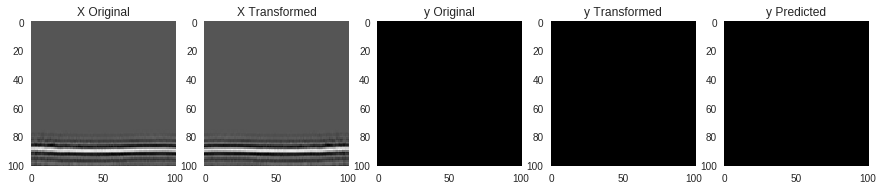

07/09/2018 06:03:36 - SaltNet - INFO - Batch Loss: 0.1951, Epoch loss_1: 0.0941, Epoch loss_2: 0.1132, Batch IOU: 0.8469, Batch Acc: 0.9809 at iter 2200, epoch 22, Time: 65m 42s


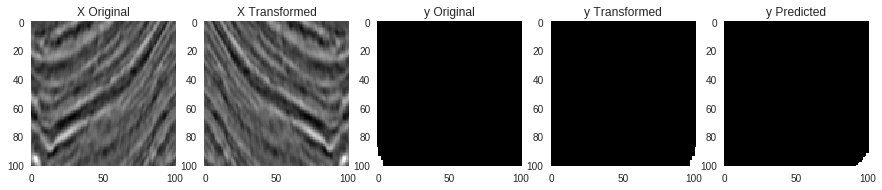

07/09/2018 06:03:38 - SaltNet - INFO - train Mean IOU: 0.8389, Mean Acc: 0.9646, Best Val IOU: 0.8154 at epoch 22
07/09/2018 06:03:49 - SaltNet - INFO - val Mean IOU: 0.8135, Mean Acc: 0.9539, Best Val IOU: 0.8154 at epoch 22
07/09/2018 06:03:49 - SaltNet - INFO - Epoch 23/150
07/09/2018 06:03:49 - SaltNet - INFO - --------------------
07/09/2018 06:05:06 - SaltNet - INFO - Batch Loss: 0.2205, Epoch loss_1: 0.1009, Epoch loss_2: 0.1196, Batch IOU: 0.8875, Batch Acc: 0.9442 at iter 2250, epoch 23, Time: 67m 12s


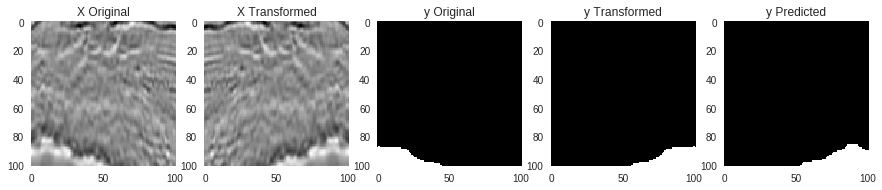

07/09/2018 06:06:23 - SaltNet - INFO - Batch Loss: 0.2002, Epoch loss_1: 0.0934, Epoch loss_2: 0.1170, Batch IOU: 0.9000, Batch Acc: 0.9632 at iter 2300, epoch 23, Time: 68m 28s


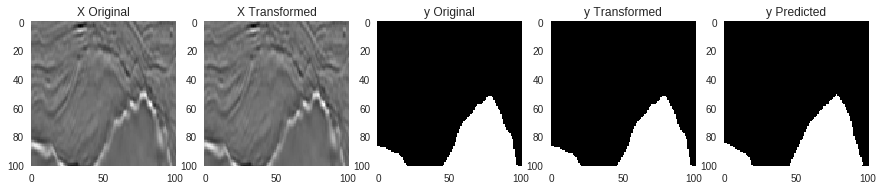

07/09/2018 06:06:24 - SaltNet - INFO - train Mean IOU: 0.8331, Mean Acc: 0.9641, Best Val IOU: 0.8154 at epoch 23
07/09/2018 06:06:35 - SaltNet - INFO - val Mean IOU: 0.8060, Mean Acc: 0.9515, Best Val IOU: 0.8154 at epoch 23
07/09/2018 06:06:35 - SaltNet - INFO - Epoch 24/150
07/09/2018 06:06:35 - SaltNet - INFO - --------------------
07/09/2018 06:06:35 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master 2b54630] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 720 bytes | 720.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   f3d8b52..2b54630  master -> master


07/09/2018 06:08:09 - SaltNet - INFO - Batch Loss: 0.2155, Epoch loss_1: 0.0971, Epoch loss_2: 0.1184, Batch IOU: 0.8875, Batch Acc: 0.9777 at iter 2350, epoch 24, Time: 70m 15s


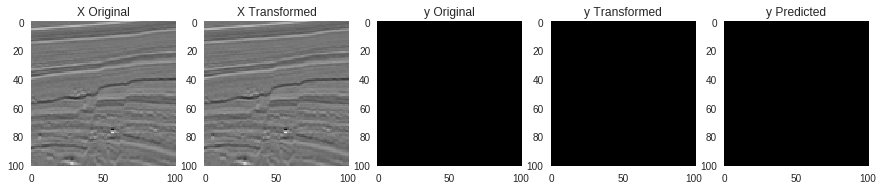

07/09/2018 06:09:26 - SaltNet - INFO - Batch Loss: 0.2061, Epoch loss_1: 0.0944, Epoch loss_2: 0.1164, Batch IOU: 0.8313, Batch Acc: 0.9859 at iter 2400, epoch 24, Time: 71m 32s


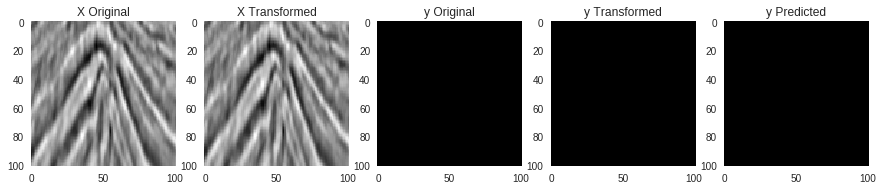

07/09/2018 06:09:28 - SaltNet - INFO - train Mean IOU: 0.8366, Mean Acc: 0.9645, Best Val IOU: 0.8154 at epoch 24
07/09/2018 06:09:39 - SaltNet - INFO - val Mean IOU: 0.8090, Mean Acc: 0.9545, Best Val IOU: 0.8154 at epoch 24
07/09/2018 06:09:39 - SaltNet - INFO - Epoch 25/150
07/09/2018 06:09:39 - SaltNet - INFO - --------------------
07/09/2018 06:10:56 - SaltNet - INFO - Batch Loss: 0.2143, Epoch loss_1: 0.0949, Epoch loss_2: 0.1194, Batch IOU: 0.8406, Batch Acc: 0.9531 at iter 2450, epoch 25, Time: 73m 2s


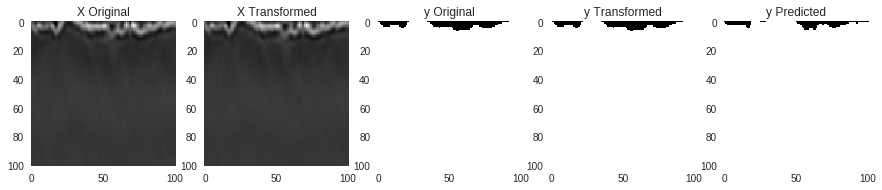

07/09/2018 06:12:13 - SaltNet - INFO - Batch Loss: 0.1952, Epoch loss_1: 0.0907, Epoch loss_2: 0.1140, Batch IOU: 0.9187, Batch Acc: 0.9894 at iter 2500, epoch 25, Time: 74m 19s


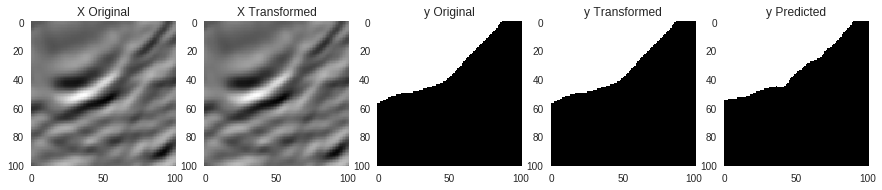

07/09/2018 06:12:14 - SaltNet - INFO - train Mean IOU: 0.8383, Mean Acc: 0.9650, Best Val IOU: 0.8154 at epoch 25
07/09/2018 06:12:25 - SaltNet - INFO - val Mean IOU: 0.8151, Mean Acc: 0.9572, Best Val IOU: 0.8154 at epoch 25
07/09/2018 06:12:25 - SaltNet - INFO - Epoch 26/150
07/09/2018 06:12:25 - SaltNet - INFO - --------------------
07/09/2018 06:12:25 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master 6d4421b] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 717 bytes | 717.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   2b54630..6d4421b  master -> master


07/09/2018 06:13:58 - SaltNet - INFO - Batch Loss: 0.2012, Epoch loss_1: 0.0873, Epoch loss_2: 0.1139, Batch IOU: 0.8313, Batch Acc: 0.9637 at iter 2550, epoch 26, Time: 76m 4s


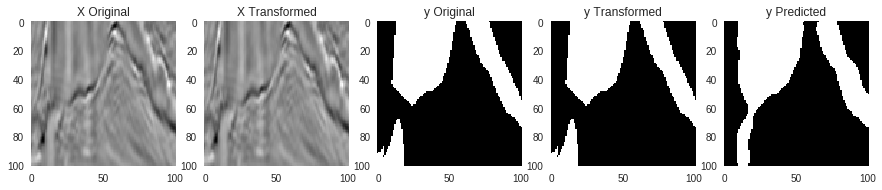

07/09/2018 06:15:16 - SaltNet - INFO - Batch Loss: 0.2092, Epoch loss_1: 0.0909, Epoch loss_2: 0.1143, Batch IOU: 0.8562, Batch Acc: 0.9619 at iter 2600, epoch 26, Time: 77m 21s


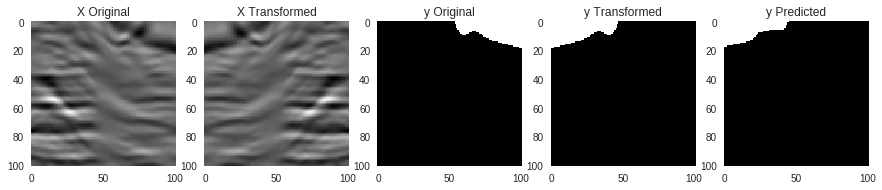

07/09/2018 06:15:17 - SaltNet - INFO - train Mean IOU: 0.8359, Mean Acc: 0.9653, Best Val IOU: 0.8154 at epoch 26
07/09/2018 06:15:28 - SaltNet - INFO - val Mean IOU: 0.8069, Mean Acc: 0.9545, Best Val IOU: 0.8154 at epoch 26
07/09/2018 06:15:28 - SaltNet - INFO - Epoch 27/150
07/09/2018 06:15:28 - SaltNet - INFO - --------------------


In [0]:
# fine tuning
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)
if torch.cuda.is_available():
  saltnet.cuda()
model_file_suffix = "../salt_net/Unet_bce_loss_lovasz_loss_2018_09_05_23_54_40.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)
optimizer.load_state_dict(model_state_dict['optimizer'])
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
scheduler.load_state_dict(model_state_dict['scheduler'])

model_save_name = f'../salt_net/Unet_bce_loss_lovasz_loss_finetune_{get_current_time_as_fname()}.ckp'
#model_save_name = None
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=150, print_every=50, save_model_every=20, save_log_every=2, log=log, loss2_weight=0.4)

In [0]:
## Train a new model
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)
loss_fn_bce = nn.BCEWithLogitsLoss()
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)

model_save_name = f'../salt_net/Unet_bce_loss_lovasz_loss_finetune_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=250, print_every=50, save_model_every=20, save_log_every=2, log=log)

## Load Trained Model

In [0]:
loaded_model = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)

Using bilinear for upsampling
Using bilinear for upsampling
Using bilinear for upsampling
Using bilinear for upsampling


In [0]:
ls

logs/
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-4-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-5-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-4-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-5-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-4-Of-5
Unet_bce_loss_bilin

In [0]:
model_file_suffix = "Unet_bce_loss_lovasz_loss_finetune_2018_09_06_11_59_40.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
loaded_model.load_state_dict(model_state_dict['model'])

### Make Predictions on validation set

### Set model to evaluation mode

In [0]:
loaded_model.eval()
assert loaded_model.training == False

In [0]:
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img, out_size=128), batch_size=16)

In [0]:
if torch.cuda.is_available():
    loaded_model.cuda()

In [0]:
y_val_pred = []

with torch.no_grad():
    for X_val_batch, y_val_batch, depth_val_batch, X_val_id_batch in val_dataLoader:
        y_val_pred.append(loaded_model(X_val_batch))
y_val_pred = torch.cat(y_val_pred)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [0]:
train_dataLoader = DataLoader(SaltDataset(X_train, y_train, depth_train, X_train_mean_img, out_size=128), batch_size=16)
y_train_pred = []

with torch.no_grad():
    for X_train_batch, y_train_batch, depth_train_batch, X_train_id_batch in train_dataLoader:
        y_train_pred.append(loaded_model(X_train_batch))
y_train_pred = torch.cat(y_train_pred)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


Image ID: 797


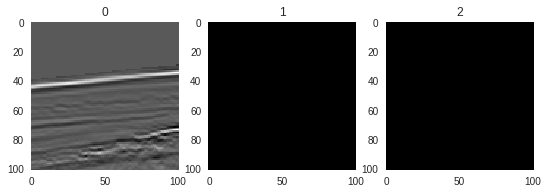

Image ID: 794


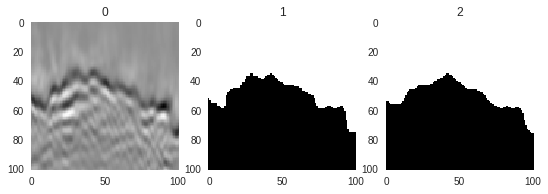

Image ID: 787


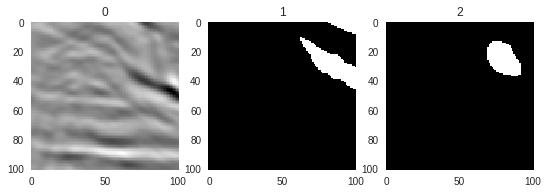

Image ID: 797


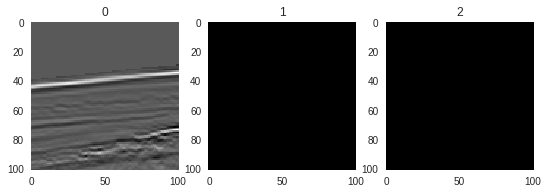

Image ID: 789


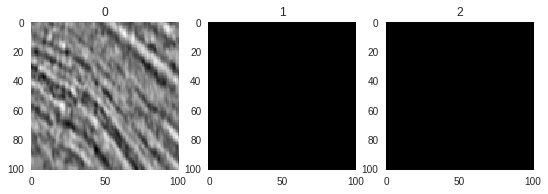

Image ID: 796


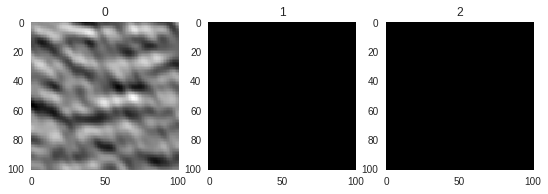

Image ID: 796


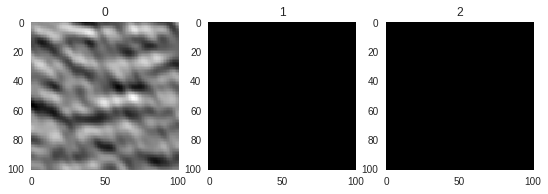

Image ID: 789


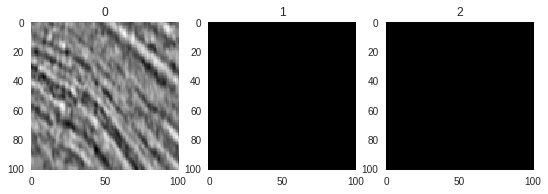

Image ID: 796


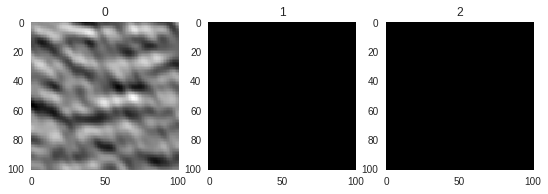

Image ID: 784


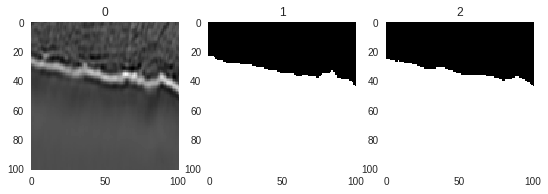

In [0]:
for i in range(10):
    rand_id = np.random.choice(X_val_id_batch)
    print(f'Image ID: {rand_id}')
    val_img = X_val[rand_id]/255
    val_mask = y_val[rand_id]
    val_mask_pred = y_val_pred.ge(MASK_CUTOFF)[rand_id]
    plot_img_mask_pred([val_img, val_mask, val_mask_pred], range(3), img_per_line=3)

Image ID: 3199


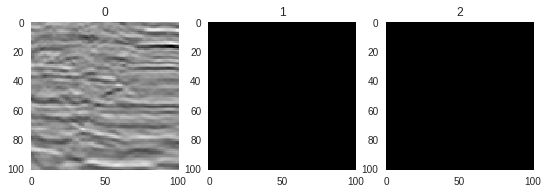

Image ID: 3192


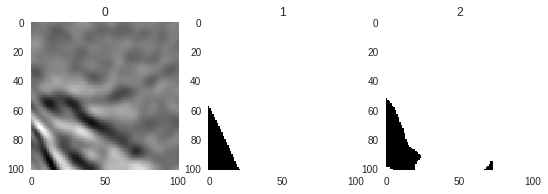

Image ID: 3185


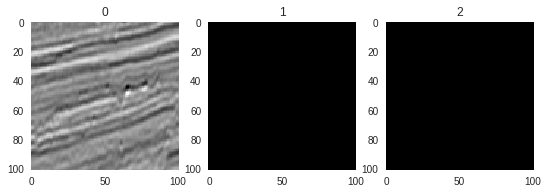

Image ID: 3192


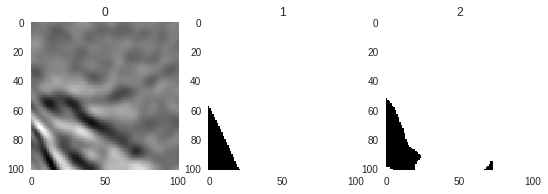

Image ID: 3188


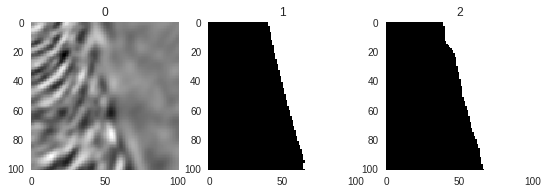

Image ID: 3193


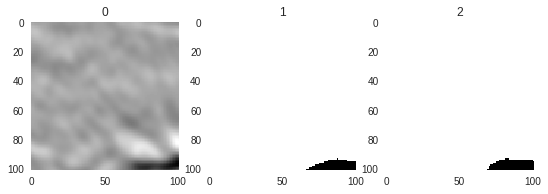

Image ID: 3192


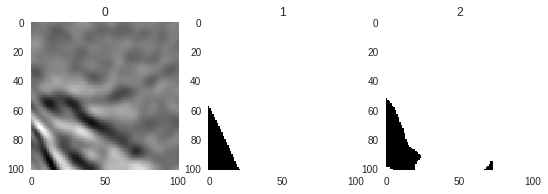

Image ID: 3192


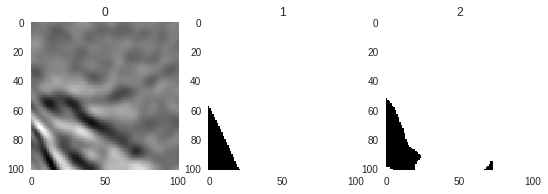

Image ID: 3188


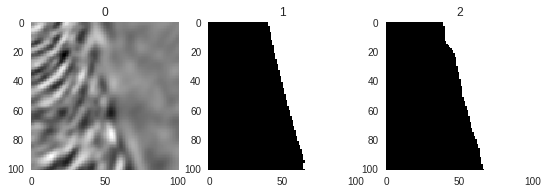

Image ID: 3192


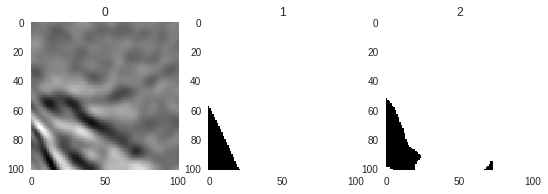

In [0]:
for i in range(10):
    rand_id = np.random.choice(X_train_id_batch)
    print(f'Image ID: {rand_id}')
    img = X_train[rand_id]/255
    mask = y_train[rand_id]
    mask_pred = y_train_pred.ge(MASK_CUTOFF)[rand_id]
    plot_img_mask_pred([img, mask, mask_pred], range(3), img_per_line=3)

In [0]:
ZERO_MASK_CUTOFF = 20
MASK_CUTOFF = 0.

In [0]:
y_val_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_val, y_val_pred.gt(MASK_CUTOFF), y_val.squeeze())

06/09/2018 05:32:56 - SaltNet - INFO - IOU score before: 0.8192499999999999, IOU Score after:0.81825


In [0]:
y_val_pred_adj = adjust_predictions(0, X_val, y_val_pred.gt(-0.3), y_val.squeeze())

06/09/2018 06:52:24 - SaltNet - INFO - IOU score before: 0.8194999999999999, IOU Score after:0.8194999999999999


In [0]:
results=[]
for cut_off in range(0, 300, 10):
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(cut_off, X_val, y_val_pred.gt(MASK_CUTOFF), y_val.squeeze()), y_val.squeeze()))

In [0]:
range(0, 300, 10)[np.argmax(results)]

0

In [0]:
results

In [0]:
y_val_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_val, y_val_pred.gt(MASK_CUTOFF), y_val.squeeze())

06/09/2018 05:33:54 - SaltNet - INFO - IOU score before: 0.8192499999999999, IOU Score after:0.81825


In [0]:
y_train_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_train, y_train_pred.gt(MASK_CUTOFF), y_train.squeeze())

06/09/2018 05:34:01 - SaltNet - INFO - IOU score before: 0.8289687499999999, IOU Score after:0.8294687500000001


In [0]:
results=[]
for cut_off in range(0, 300, 10):
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(cut_off, X_train, y_train_pred.gt(MASK_CUTOFF), y_train.squeeze()), y_train.squeeze()))

In [0]:
range(0, 3000, 10)[np.argmax(results)]

20

## Make predictions on test set

In [0]:
#test_dataLoader = DataLoader(SaltDataset(np_test[:10], None, depth_test, X_train_mean_img), batch_size=4)
test_dataLoader = DataLoader(SaltDataset(X_test, np.zeros_like(X_test), depth_test, X_train_mean_img, out_size=128), batch_size=16)

In [0]:
y_test_pred_raw = []
with torch.no_grad():
    for X_test_batch, y_test_batch, depth_test_batch, X_test_id_batch in test_dataLoader:
        y_test_pred_raw.append(loaded_model(X_test_batch))
y_test_pred = torch.cat(y_test_pred_raw)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


### Show segmentation masks for a few images

In [0]:
for i in range(10):
    rand_id = np.random.choice(X_test_id_batch)
    print(f'Image ID: {rand_id}')
    img = X_test[rand_id]/255
    mask_pred = y_test_pred.ge(0.5)[rand_id]
    plot_img_mask_pred([img, mask_pred], range(2))

### Adjust predictions

In [0]:
 ZERO_MASK_CUTOFF = 0.

In [0]:
y_test_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_test, y_test_pred.gt(MASK_CUTOFF))

### Encode predictions using RLE(Run Length Encoding) method

In [0]:
y_test_pred_rle = rle_encoder3d(y_test_pred_adj)

In [0]:
y_test_pred_adj.shape

(18000, 101, 101)

In [0]:
df_test_rle = pd.DataFrame(index=misc_data['np_test_ids'], data=y_test_pred_rle).reset_index()

In [0]:
df_test_rle.columns = ['id', 'rle_mask']

In [0]:
df_test_rle[df_test_rle.rle_mask==''].shape

(7807, 2)

In [0]:
df_test_rle.shape

(18000, 2)

In [0]:
df_test_rle.to_csv(f'submission_{get_current_time_as_fname()}.csv', index=False)

In [0]:
ls

logs/
submission_2018_09_06_16_20_54.csv
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-4-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-5-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-4-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-5-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.c

In [0]:
from google.colab import files


In [0]:
files.download('submission_2018_09_06_16_20_54.csv') 

In [0]:
y_pred_adj = adjust_predictions(0, X_val, y_val_pred.gt(MASK_CUTOFF))

In [0]:
df_test_rle = pd.DataFrame(depth_val, columns=['z'])

In [0]:
df_test_rle['num_salt_pix'] = y_pred_adj.sum((1,2))

In [0]:
df_test_rle.head()

,z,num_salt_pix
id,,
25db231ea0,581,3773
dfd3138198,373,0
2425501bf4,788,0
fbb8eba26d,743,0
bea9b0571b,366,9422


In [0]:
exp_black_mask_pct = [0.822, 0.755, 0.707, 0.568, 0.464, 0.378, 0.289, 0.285, 0.317, 0.25, 0.354, 0.255, 0.339, 0.357, 0.385, 0.442, 0.65, 0.58, 0.778]

In [0]:
df_test_z_grp

,total,black_mask,black_mask_pct
z_bin,,,
50,16.0,15.0,0.937500
100,31.0,21.0,0.677419
150,28.0,24.0,0.857143
200,47.0,28.0,0.595745
250,34.0,17.0,0.500000
300,45.0,15.0,0.333333
350,55.0,21.0,0.381818
400,48.0,20.0,0.416667
450,75.0,26.0,0.346667


In [0]:
len(exp_black_mask_pct)

19

In [0]:
df_test_rle['z_bin'] = df_test_rle.z.floordiv(50).mul(50)
df_test_rle['black_mask'] = df_test_rle.num_salt_pix==0
df_test_z_grp = (
    df_test_rle.groupby('z_bin')
    .apply(lambda x: pd.Series([len(x),
                               x.black_mask.sum(),
                               x.black_mask.sum()/len(x)],
                               ['total','black_mask', 'black_mask_pct'])
          )
    #.sort_values('black_mask_pct', ascending=False)
)
df_test_z_grp['exp_black_mask_pct'] = exp_black_mask_pct[:-1]

In [0]:
df_test_rle.head()

,z,num_salt_pix,z_bin,black_mask
id,,,,
25db231ea0,581,3773,550,False
dfd3138198,373,0,350,True
2425501bf4,788,0,750,True
fbb8eba26d,743,0,700,True
bea9b0571b,366,9422,350,False


In [0]:
df_test_z_grp

,total,black_mask,black_mask_pct,exp_black_mask_pct
z_bin,,,,
50,16.0,15.0,0.937500,0.822
100,31.0,21.0,0.677419,0.755
150,28.0,24.0,0.857143,0.707
200,47.0,28.0,0.595745,0.568
250,34.0,17.0,0.500000,0.464
300,45.0,15.0,0.333333,0.378
350,55.0,21.0,0.381818,0.289
400,48.0,20.0,0.416667,0.285
450,75.0,26.0,0.346667,0.317
